# NHL Draft data from NHL Records API

Dataset generated from a JSON received from the NHL Records API, contains response to the request for all draft records.

For details, see notebook `notebooks/feature_extraction/nhl_api.ipynb`.

# Data cleanup and feature extraction

## Load data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from time import time
import os

In [5]:
os.chdir('Documents/repos/nhl_draft/')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 'data',
 'design',
 'main.py',
 'models',
 'notebooks',
 'README.md',
 'requirements.txt']

In [8]:
draft_api_data_path = 'data/nhl_api/nhl_draft_all.csv'
t = time()
df = pd.read_csv(draft_api_data_path,
                 parse_dates=['birthDate',
                              'draftYear'])
# df = df.rename(columns={'Unnamed: 0': 'id'})
elapsed = time() - t
print("----- DataFrame with NHL Draft Data loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with NHL Draft Data loaded
in 0.25 seconds
with 11,587 rows
and 25 columns
-- Column names:
 Index(['amateurClubName', 'amateurLeague', 'birthDate', 'birthPlace',
       'countryCode', 'csPlayerId', 'draftYear', 'draftedByTeamId',
       'firstName', 'height', 'id', 'lastName', 'overallPickNumber',
       'pickInRound', 'playerId', 'playerName', 'position', 'removedOutright',
       'removedOutrightWhy', 'roundNumber', 'shootsCatches',
       'supplementalDraft', 'teamPickHistory', 'triCode', 'weight'],
      dtype='object')


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11587 entries, 0 to 11586
Data columns (total 25 columns):
amateurClubName       11492 non-null object
amateurLeague         11471 non-null object
birthDate             11526 non-null datetime64[ns]
birthPlace            11530 non-null object
countryCode           11580 non-null object
csPlayerId            4854 non-null float64
draftYear             11587 non-null datetime64[ns]
draftedByTeamId       11587 non-null int64
firstName             11580 non-null object
height                11502 non-null float64
id                    11587 non-null int64
lastName              11580 non-null object
overallPickNumber     11587 non-null int64
pickInRound           11587 non-null int64
playerId              10800 non-null float64
playerName            11580 non-null object
position              11580 non-null object
removedOutright       11587 non-null object
removedOutrightWhy    88 non-null object
roundNumber           11587 non-null int64
s

## Data cleanup

Fixing inconsistent capitalizations

In [10]:
col = 'amateurClubName'
df[col] = df[col].str.title()
print("Capitalizations fixed!")

Capitalizations fixed!


### Some inconsistencies in amateur club names

In [11]:
col = 'amateurClubName'
mask = df[col].str.contains('london', case=False).fillna(False)
df.loc[mask,col].value_counts()

London Knights           115
London                    64
London Nationals           3
London Jr. B               1
London Diamonds Jr. B      1
Name: amateurClubName, dtype: int64

In [12]:
mask = df[col].str.contains('peterbo', case=False).fillna(False)
df.loc[mask,col].value_counts()

Peterborough Petes    144
Peterborough           41
Peterboro               1
Name: amateurClubName, dtype: int64

#### Inconsistent names for Russian teams
##### Fix team names for St. Petersburg SKA

In [13]:
col = 'amateurClubName'
ska = ['Ska Leningrad', 
       'St. Petersburg Ska',
       'Ska St. Petersburg',
       'Leningrad Ska',
       'St. Petersburg Ska St. Petersburg']
mask = df[col].isin(ska)
df.loc[mask, col] = 'Ska'
print("The following Amateur Team names:\n", ska,
      "\nhave been renamed to 'Ska'")

The following Amateur Team names:
 ['Ska Leningrad', 'St. Petersburg Ska', 'Ska St. Petersburg', 'Leningrad Ska', 'St. Petersburg Ska St. Petersburg'] 
have been renamed to 'Ska'


In [14]:
df[col] = df[col].str.replace("Ska St. Petersburg 2",
                              "Ska 2")
print("Replaced.")

Replaced.


##### Fix team names for Moscow CSKA

In [15]:
cska = ['Cska Moscow', 'Hc Cska', 'Cska']
cska_jun = ['Cska 2', 'Cska Jr.',
            'Cska 2 Cska Moscow 2']
mask = df[col].isin(cska)
df.loc[mask, col] = "Cska"
print("The following Amateur Team names:\n", cska,
      "\nhave been renamed to 'Cska'"
      "\n{0:,} records total".format(len(df[mask])))

mask = df[col].isin(cska_jun)
df.loc[mask, col] = "Cska 2"
print("\nThe following Amateur Team names:\n", cska_jun,
      "\nhave been renamed to 'Cska 2'"
      "\n{0:,} records total".format(len(df[mask])))

The following Amateur Team names:
 ['Cska Moscow', 'Hc Cska', 'Cska'] 
have been renamed to 'Cska'
75 records total

The following Amateur Team names:
 ['Cska 2', 'Cska Jr.', 'Cska 2 Cska Moscow 2'] 
have been renamed to 'Cska 2'
19 records total


In [16]:
mask1 = df[col].str.contains('peterbu', case=False).fillna(False)
mask2 = df[col].str.contains('ska', case=False)
df.loc[mask1 | mask2,col].value_counts()

Saskatoon Blades             93
Cska                         75
Saskatoon                    36
Cska 2                       19
Ska                           9
Ska 2                         6
U. Of Alaska-Anchorage        4
Banska Bystrica               3
U. Of Nebraska-Omaha          3
Oskarshamn                    2
Nebraska-Omaha                2
Chaska                        2
Fort Saskatchewan             2
U. Of Alaska-Fairbanks        2
Alaska-Fairbanks              1
Skalica Jr.                   1
Saskatoon J'S                 1
Alaska All-Stars              1
Fort Saskatchewan Traders     1
Skalica                       1
Spisska Nova Ves              1
Spisska Nova Ves Jr.          1
Name: amateurClubName, dtype: int64

### `pickInRound` seems have erratic values
New variable for round of the pick will be generated based on `overallPickNumber`, which appears to be more consistent. This will be performed in step `feature_extraction`.

### Fixing inconsistent Russian league names

In [17]:
col = 'amateurLeague'
mask = df[col].str.contains('ru', case=False).fillna(False)
df.loc[mask,col].value_counts()

Russia          276
RUS             122
RUSSIA-JR.       83
RUSSIA           35
RUSSIA-3         23
RUSSIA-2         13
RUSSIA-1          7
RUSSIA JR. 2      1
Name: amateurLeague, dtype: int64

In [18]:
rus = ['Russia', 'RUS', 'RUSSIA', 'RUSSIA-1']
mask = df[col].isin(rus)
df.loc[mask, col] = 'Russia'
print("{0} values fixed.".format(len(df[mask])))

440 values fixed.


In [19]:
rus_jun = ['RUSSIA-JR.', 'RUSSIA JR. 2']
mask = df[col].isin(rus_jun)
df.loc[mask, col] = 'Russia-Jr.'
print("{0} values fixed.".format(len(df[mask])))

84 values fixed.


In [20]:
mask = df[col].str.contains('ru', case=False).fillna(False)
df.loc[mask,col].value_counts()

Russia        440
Russia-Jr.     84
RUSSIA-3       23
RUSSIA-2       13
Name: amateurLeague, dtype: int64

### Country codes are consistent

### Fixing inconsistent player name capitalizations

In [21]:
col = 'playerName'
df[col] = df[col].str.title()
col = 'lastName'
df[col] = df[col].str.title()
print("Player name capitalizations fixed!")

Player name capitalizations fixed!


### Number of records per year appears to match historical NHL Draft records
Number of picks per draft year can be verified [here](https://en.wikipedia.org/wiki/NHL_Entry_Draft).

In [22]:
df['draftYear'].value_counts().sort_index()

1963-01-01     21
1964-01-01     24
1965-01-01     10
1966-01-01     24
1967-01-01     18
1968-01-01     24
1969-01-01     84
1970-01-01    116
1971-01-01    117
1972-01-01    152
1973-01-01    168
1974-01-01    247
1975-01-01    216
1976-01-01    135
1977-01-01    185
1978-01-01    234
1979-01-01    126
1980-01-01    210
1981-01-01    211
1982-01-01    252
1983-01-01    242
1984-01-01    252
1985-01-01    252
1986-01-01    252
1987-01-01    252
1988-01-01    252
1989-01-01    252
1990-01-01    252
1991-01-01    264
1992-01-01    264
1993-01-01    286
1994-01-01    286
1995-01-01    234
1996-01-01    241
1997-01-01    246
1998-01-01    258
1999-01-01    272
2000-01-01    293
2001-01-01    289
2002-01-01    291
2003-01-01    292
2004-01-01    291
2005-01-01    230
2006-01-01    213
2007-01-01    211
2008-01-01    211
2009-01-01    210
2010-01-01    210
2011-01-01    210
2012-01-01    211
2013-01-01    211
2014-01-01    210
2015-01-01    211
2016-01-01    211
2017-01-01    217
2018-01-01

### `birthDate` values appear to be reasonable

In [23]:
df['birthDate'].describe()

count                   11526
unique                   8313
top       1976-04-04 00:00:00
freq                        6
first     1944-10-08 00:00:00
last      2001-09-11 00:00:00
Name: birthDate, dtype: object

### `birthPlace` values appear to be reasonable
### `draftByTeamId` values appear to be reasonable
### `overallPickNumber` values appear to be reasonable

### Fixing erratic `height` values

count    11502.000000
mean        72.675882
std          2.257367
min         65.000000
25%         71.000000
50%         73.000000
75%         74.000000
max        150.000000
Name: height, dtype: float64

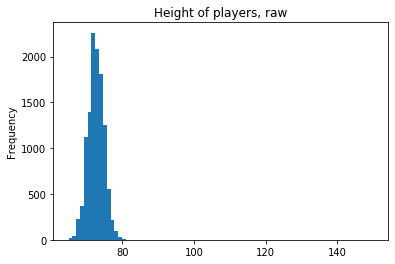

In [24]:
col = 'height'
df[col].plot(kind='hist', bins=80,
             title="Height of players, raw")
df[col].describe()

In [25]:
mask = df[col] > 90
df[mask]

,amateurClubName,amateurLeague,birthDate,birthPlace,countryCode,csPlayerId,draftYear,draftedByTeamId,firstName,height,...,playerName,position,removedOutright,removedOutrightWhy,roundNumber,shootsCatches,supplementalDraft,teamPickHistory,triCode,weight
4181,Timra,Sweden,1962-03-02,"Federtalve, Sweden",SWE,NaN,1980-01-01,15,Peter,150.0,...,Peter Andersson,D,N,NaN,9,R,N,WSH,WSH,150.0
8919,Cherepovets Severstal,Russia,1981-06-23,"Ust-Kamenogorsk, Kazakhstan",KAZ,45565.0,1999-01-01,4,Konstantin,123.0,...,Konstantin Rudenko,LW,N,NaN,6,R,N,PHI,PHI,123.0


In [26]:
df.loc[mask, col] = df[col].mean()
print("Erratic height values replaced with mean.")

Erratic height values replaced with mean.


count    11502.000000
mean        72.664785
std          2.086986
min         65.000000
25%         71.000000
50%         73.000000
75%         74.000000
max         81.000000
Name: height, dtype: float64

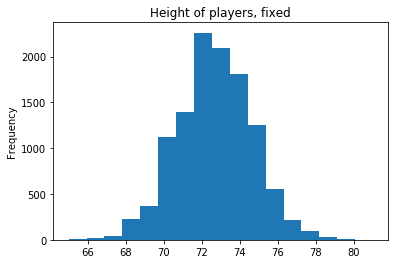

In [27]:
col = 'height'
df[col].plot(kind='hist', bins=17,
             title="Height of players, fixed")
df[col].describe()

Height of players follows a normal (Gaussian) distribution, as expected.

### Fixing erratic `weight` values

count    11502.000000
mean       191.407494
std         16.242026
min         19.000000
25%        180.000000
50%        190.000000
75%        201.000000
max        265.000000
Name: weight, dtype: float64

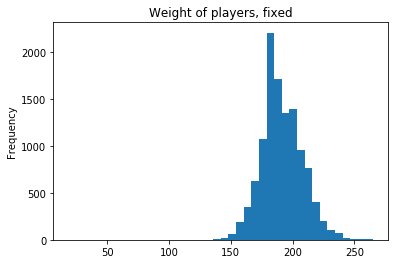

In [28]:
col = 'weight'
df[col].plot(kind='hist', bins=40,
             title="Weight of players, fixed")
df[col].describe()

In [29]:
mask = df[col] < 130
df[mask]

,amateurClubName,amateurLeague,birthDate,birthPlace,countryCode,csPlayerId,draftYear,draftedByTeamId,firstName,height,...,playerName,position,removedOutright,removedOutrightWhy,roundNumber,shootsCatches,supplementalDraft,teamPickHistory,triCode,weight
8365,Notre Dame,NCAA,1978-06-14,"Shaker Heights, OH USA",USA,47155.0,1997-01-01,16,Benjamin,72.000000,...,Benjamin Simon,LW,N,NaN,5,L,N,CHI,CHI,19.0
8496,NaN,Czech Republic,1974-02-22,"Benesov, Czech Republic",CZE,47965.0,1997-01-01,1,Jan,72.000000,...,Jan Srdinko,D,N,NaN,9,L,N,NJD,NJD,100.0
8919,Cherepovets Severstal,Russia,1981-06-23,"Ust-Kamenogorsk, Kazakhstan",KAZ,45565.0,1999-01-01,4,Konstantin,72.675882,...,Konstantin Rudenko,LW,N,NaN,6,R,N,PHI,PHI,123.0


In [30]:
df.loc[mask, col] = df[col].mean()
print("Erratic weight values replaced with mean.")

Erratic weight values replaced with mean.


count    11502.000000
mean       191.436378
std         16.127142
min        137.000000
25%        180.000000
50%        190.000000
75%        201.000000
max        265.000000
Name: weight, dtype: float64

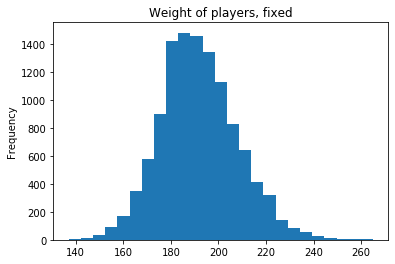

In [31]:
df[col].plot(kind='hist', bins=25,
             title="Weight of players, fixed")
df[col].describe()

Weight of players follows a normal (Gaussian) distribution, as expected.

### Remove redundant positions
All players capable of playing the center are assumed to be centers, LW/RW are assumed to be right wings, mixed D positions are assumed to be D.

In [32]:
col = 'position'
df[col].value_counts()

D        3786
C        2456
LW       1903
RW       1855
G        1156
F         362
C/LW       30
C/RW       17
LW/RW      13
LW/D        1
D/F         1
Name: position, dtype: int64

In [33]:
df[col] = df[col].str.replace("C/LW", "C")
df[col] = df[col].str.replace("C/RW", "C")
df[col] = df[col].str.replace("LW/RW", "RW")
df[col] = df[col].str.replace("LW/D", "D")
df[col] = df[col].str.replace("D/F", "D")
df[col] = df[col].str.replace("F", "C")
df[col].value_counts()

D     3788
C     2865
LW    1903
RW    1868
G     1156
Name: position, dtype: int64

## Filter and rename columns

In [34]:
cols = ['playerName', 'countryCode', 
        'birthDate', 'birthPlace',
        'amateurClubName', 'amateurLeague',
        'draftYear', 'draftedByTeamId', 
        'overallPickNumber', 'removedOutright',
        'removedOutrightWhy', 'height',
        'weight', 'position', 'shootsCatches']
col_names = ['name', 'nat', 'dob', 'bp', 'ateam', 
             'league', 'year', 'dteam', 'overall',
             'removed', 'why', 'height', 'weight', 
             'pos', 'shoots', ]
df_filtered = df[cols].copy()
df_filtered.columns = col_names
print("DataFrame columns filtered and renamed.")

DataFrame columns filtered and renamed.


## Record results to a new .csv file

In [38]:
save_path = 'data/nhl_api/nhl_draft_all_cleaned.csv'
t = time()
df_filtered.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds".format(elapsed))

DataFrame saved to file:
 data/nhl_api/nhl_draft_all_cleaned.csv 
took 0.47 seconds
